In [1]:
#
# This notebook implements a minimal cell-cycle oscillator defined by Equations 7-9
# in (Gerand, Tyson, and Novak, Biophys. J., 2013)
#

In [2]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from dataclasses import dataclass
import seaborn as sns

In [3]:
# Parameter defiition
# Note that the notation is slightly modified from the paper to give better distinguishability on the computer display
#
@dataclass
class Parameters:
    totalAPC: float # = APC + APCp (Note that this model ignores multiple phospholyration)
    V_scdk: float # Spontaneous Cdk synthesis rate
    d_d1cdk: float # Spontaneous Cdk decay rate
    d_dcdk: float # APCp-dependent Cdk decay rate
    K_dcdk: float
    V_2APC: float
    K_2APC: float
    V_1APC: float
    K_1APC: float
    V_ssec: float
    d_d1sec: float
    d_dsec: float
    K_dsec: float # Dissociation constant between APCp and Cyclin-CDK

params = Parameters(totalAPC=1, V_scdk=0.06, d_d1cdk=0.01, d_dcdk=0.35, K_dcdk=0.01,
                   V_2APC=0.3, K_2APC=0.01, V_1APC=0.15, K_1APC=0.01,
                   V_ssec=0.1, d_d1sec=0.01, d_dsec=0.4, K_dsec=0.001)

#
# Model equations that define time derivatives of signal levels
#
def min_oscillator(x, time, p):
    Cdk = x[0]
    APCp = x[1]
    Sec = x[2]
    APC = p.totalAPC - APCp# assuming total APC amount is constant
    f = np.zeros((3,))
    MM1 = Cdk / (p.K_dcdk * (1 + (Sec / p.K_dsec)) + Cdk)# Michaelis-Menten with competitive inhibition formula
    MM2 = Sec / (p.K_dsec * (1 + (Cdk / p.K_dcdk)) + Sec)
    f[0] = p.V_scdk - p.d_d1cdk * Cdk - p.d_dcdk * APCp * MM1#  Eq. 7
    f[1] = p.V_2APC * Cdk * APC/(p.K_2APC + APC) - p.V_1APC * APCp /(p.K_1APC + APCp)# Eq. 8
    f[2] = p.V_ssec - p.d_d1sec * Sec - p.d_dsec * APCp * MM2# Eq. 9
    return f

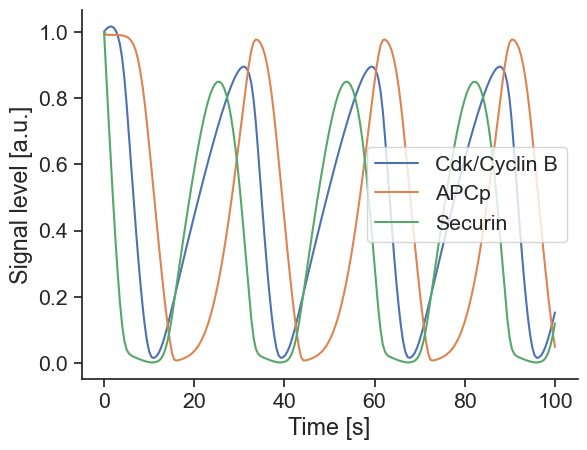

In [4]:
#
# Numetical integration.
# 'odeint' uses Adams methods for non-stiff systems and backward differentiation formula methods for stiff systems.
#
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.4, rc=custom_params)

params.K_dsec = 0.001# Increasing the dissociation constant causes the oscillations to stop

time_points = np.linspace(0, 100, 200)# timepoints for ode solver
xinit = [1, 1, 1]
xvec = integrate.odeint(min_oscillator, xinit, time_points, args=(params,))
#
# Plot simulation result
#
plt.plot(time_points, xvec[:, 0], label='Cdk/Cyclin B')
plt.plot(time_points, xvec[:, 1], label='APCp')
plt.plot(time_points, xvec[:, 2], label='Securin')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Signal level [a.u.]')
plt.show()

0 th parameter value examined.
20 th parameter value examined.
40 th parameter value examined.
60 th parameter value examined.
80 th parameter value examined.


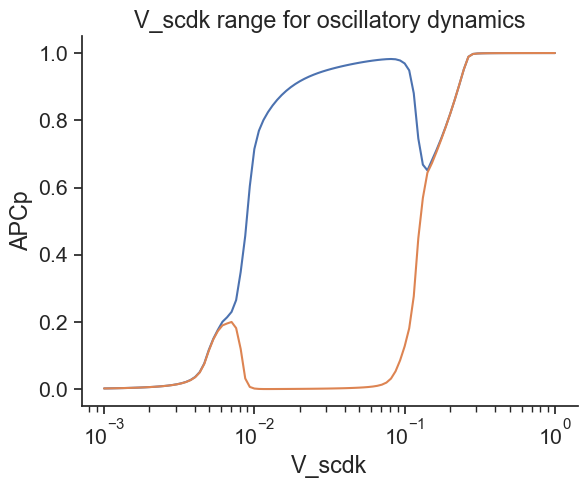

In [5]:
#
# Bifurcation diagram using APCp along with V_scdk
#
vs = np.logspace(-3, 0, num=100)# define V_scdk values to be examined (in the log scale)
APCp_max = np.zeros((100,))
APCp_min = np.zeros((100,))
time_points = np.linspace(0, 300, 3000)
xinit = [0.1, 0.1, 0.1]
for n, v in enumerate(vs):
    params.V_scdk = v
    xvec = integrate.odeint(min_oscillator, xinit, time_points, args=(params,))
    xinit = xvec[-1, :]
    APCp_max[n] = np.max(xvec[2000:, 1])
    APCp_min[n] = np.min(xvec[2000:, 1])
    if n%20 == 0:
        print("%d th parameter value examined." % n)

plt.plot(vs, APCp_max)
plt.plot(vs, APCp_min)
plt.xscale("log")
plt.xlabel('V_scdk')
plt.ylabel('APCp')
plt.title('V_scdk range for oscillatory dynamics')
plt.show()